# CNN Training with Keras
This script trains a Convolutional Neural Network (CNN) on the CIFAR-10 dataset using Keras. It includes hyperparameter analysis and saves the best model's weights.

In [23]:
# Import Required Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Data Preparation Function
def load_and_preprocess_data():
    (x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()

    # Split training into train and validation (40k train, 10k val)
    x_train, x_val, y_train, y_val = train_test_split(
        x_train_full, y_train_full, test_size=0.2, random_state=42 # 0.2 of 50k is 10k for validation
    )

    # Normalize pixel values to be between 0 and 1
    x_train = x_train.astype("float32") / 255.0
    x_val = x_val.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    print(f"x_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"x_val shape: {x_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [ ]:
# CNN Model Building Function
def build_cnn_model(num_conv_layers, filters_per_layer, filter_size, pooling_type, input_shape, num_classes=10):
    model = keras.Sequential()
    model.add(keras.Input(shape=input_shape))

    # Add Convolutional and Pooling layers
    for i in range(num_conv_layers):
        model.add(layers.Conv2D(filters_per_layer[i], filter_size, activation='relu', padding='same'))
        if pooling_type == 'max':
            model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        elif pooling_type == 'avg':
            model.add(layers.AveragePooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu')) # Example dense layer
    model.add(layers.Dense(num_classes, activation='softmax')) # Output layer

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Setup: Load data and define configs
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_and_preprocess_data()
input_shape = x_train.shape[1:]
num_classes = 10
results = []
best_f1_score = -1
best_model_config = None
best_keras_model = None
hyperparameter_configs = [
    {'num_conv_layers': 1, 'filters_per_layer': [32], 'filter_size': (3,3), 'pooling_type': 'max'},
    {'num_conv_layers': 2, 'filters_per_layer': [32, 64], 'filter_size': (3,3), 'pooling_type': 'max'},
    {'num_conv_layers': 3, 'filters_per_layer': [32, 64, 128], 'filter_size': (3,3), 'pooling_type': 'max'},
    {'num_conv_layers': 2, 'filters_per_layer': [16, 32], 'filter_size': (3,3), 'pooling_type': 'max'},
    {'num_conv_layers': 2, 'filters_per_layer': [64, 128], 'filter_size': (3,3), 'pooling_type': 'max'},
    {'num_conv_layers': 2, 'filters_per_layer': [32, 64], 'filter_size': (5,5), 'pooling_type': 'max'},
    {'num_conv_layers': 2, 'filters_per_layer': [32, 64], 'filter_size': (3,3), 'pooling_type': 'avg'},
]

x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 1)
x_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)



--- Training Model with Configuration 1: {'num_conv_layers': 1, 'filters_per_layer': [32], 'filter_size': (3, 3), 'pooling_type': 'max'} ---


2025-05-15 22:25:30.468550: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-05-15 22:25:30.469053: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-15 22:25:30.469066: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1747322730.474795 15622767 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747322730.474858 15622767 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,050,890 (4.01 MB)

 Trainable params: 1,050,890 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-05-15 22:25:31.645301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.3656 - loss: 1.7659 - val_accuracy: 0.5206 - val_loss: 1.3729
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.3656 - loss: 1.7659 - val_accuracy: 0.5206 - val_loss: 1.3729
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5473 - loss: 1.2838 - val_accuracy: 0.5820 - val_loss: 1.2100
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5473 - loss: 1.2838 - val_accuracy: 0.5820 - val_loss: 1.2100
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5850 - loss: 1.2038 - val_accuracy: 0.5663 - val_loss: 1.2801
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5850 - loss: 1.2038 - val_accuracy: 0.5663 - val_loss: 1.2801
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5873 - loss: 1.2344 - val_accuracy: 0.5501 - val_loss: 1.4391
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5873 - loss: 1.2344 - val

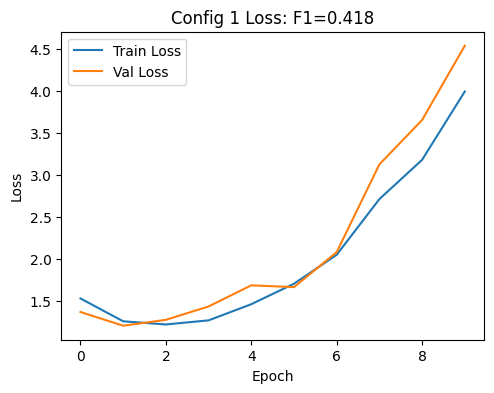

New best model found with F1-score: 0.4178


In [ ]:
# Config 1
config = hyperparameter_configs[0]
print(f"\n--- Training Model with Configuration 1: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Config 1 - Test Macro F1-Score: {macro_f1:.4f}")
results.append({'config': config, 'history': history.history, 'macro_f1': macro_f1})
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Config 1 Loss: F1={macro_f1:.3f}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
if macro_f1 > best_f1_score:
    best_f1_score = macro_f1
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 2: {'num_conv_layers': 2, 'filters_per_layer': [32, 64], 'filter_size': (3, 3), 'pooling_type': 'max'} ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3727 - loss: 1.7297 - val_accuracy: 0.5503 - val_loss: 1.2766
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3727 - loss: 1.7297 - val_accuracy: 0.5503 - val_loss: 1.2766
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5689 - loss: 1.2161 - val_accuracy: 0.5707 - val_loss: 1.2632
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5689 - loss: 1.2161 - val_accuracy: 0.5707 - val_loss: 1.2632
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5936 - loss: 1.2092 - val_accuracy: 0.5339 - val_loss: 1.5740
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5936 - loss: 1.2092 - val_accuracy: 0.5339 - val_loss: 1.5740
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5605 - loss: 1.6247 - val_accuracy: 0.5048 - val_loss: 2.8489
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5605 -

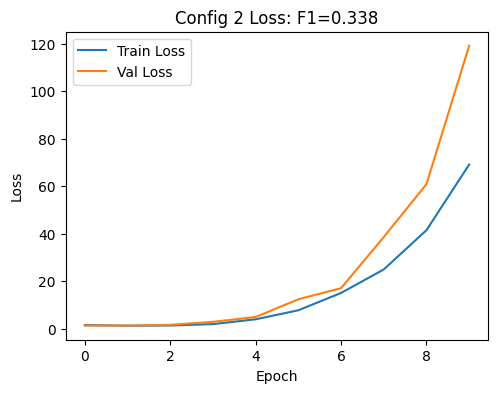

In [ ]:
# Config 2
config = hyperparameter_configs[1]
print(f"\n--- Training Model with Configuration 2: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Config 2 - Test Macro F1-Score: {macro_f1:.4f}")
results.append({'config': config, 'history': history.history, 'macro_f1': macro_f1})
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Config 2 Loss: F1={macro_f1:.3f}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
if macro_f1 > best_f1_score:
    best_f1_score = macro_f1
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 3: {'num_conv_layers': 3, 'filters_per_layer': [32, 64, 128], 'filter_size': (3, 3), 'pooling_type': 'max'} ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.3550 - loss: 1.7506 - val_accuracy: 0.5542 - val_loss: 1.2682
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.3550 - loss: 1.7506 - val_accuracy: 0.5542 - val_loss: 1.2682
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5927 - loss: 1.1458 - val_accuracy: 0.6207 - val_loss: 1.0737
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5927 - loss: 1.1458 - val_accuracy: 0.6207 - val_loss: 1.0737
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6523 - loss: 1.0146 - val_accuracy: 0.6553 - val_loss: 1.0374
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6523 - loss: 1.0146 - val_accuracy: 0.6553 - val_loss: 1.0374
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6497 - loss: 1.1106 - val_accuracy: 0.6266 - val_loss: 1.3568
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6497 -

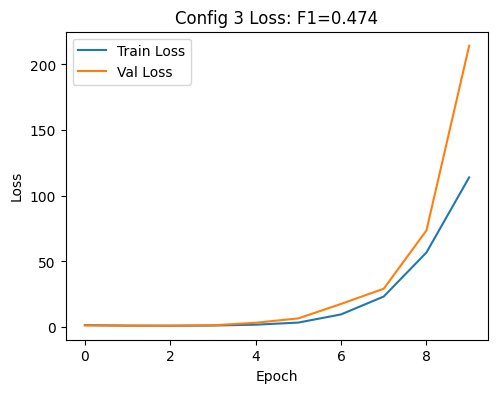

New best model found with F1-score: 0.4738


In [ ]:
# Config 3
config = hyperparameter_configs[2]
print(f"\n--- Training Model with Configuration 3: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Config 3 - Test Macro F1-Score: {macro_f1:.4f}")
results.append({'config': config, 'history': history.history, 'macro_f1': macro_f1})
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Config 3 Loss: F1={macro_f1:.3f}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
if macro_f1 > best_f1_score:
    best_f1_score = macro_f1
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 4: {'num_conv_layers': 2, 'filters_per_layer': [16, 32], 'filter_size': (3, 3), 'pooling_type': 'max'} ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,650 (1.02 MB)

 Trainable params: 268,650 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3664 - loss: 1.7409 - val_accuracy: 0.5527 - val_loss: 1.2709
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3664 - loss: 1.7409 - val_accuracy: 0.5527 - val_loss: 1.2709
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5768 - loss: 1.1943 - val_accuracy: 0.6015 - val_loss: 1.1300
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5768 - loss: 1.1943 - val_accuracy: 0.6015 - val_loss: 1.1300
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6122 - loss: 1.1139 - val_accuracy: 0.6105 - val_loss: 1.1707
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6122 - loss: 1.1139 - val_accuracy: 0.6105 - val_loss: 1.1707
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6062 - loss: 1.2022 - val_accuracy: 0.5851 - val_loss: 1.3687
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6062 -

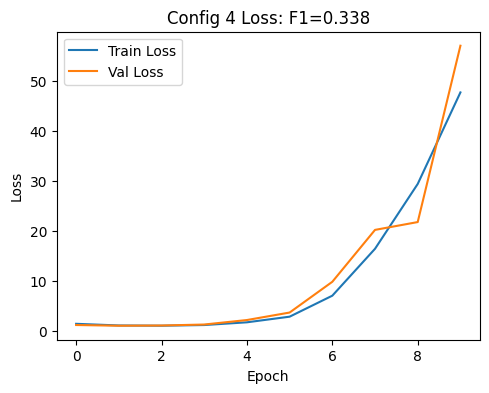

In [ ]:
# Config 4
config = hyperparameter_configs[3]
print(f"\n--- Training Model with Configuration 4: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Config 4 - Test Macro F1-Score: {macro_f1:.4f}")
results.append({'config': config, 'history': history.history, 'macro_f1': macro_f1})
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Config 4 Loss: F1={macro_f1:.3f}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
if macro_f1 > best_f1_score:
    best_f1_score = macro_f1
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 5: {'num_conv_layers': 2, 'filters_per_layer': [64, 128], 'filter_size': (3, 3), 'pooling_type': 'max'} ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,642 (4.29 MB)

 Trainable params: 1,125,642 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3789 - loss: 1.7046 - val_accuracy: 0.5744 - val_loss: 1.2125
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3789 - loss: 1.7046 - val_accuracy: 0.5744 - val_loss: 1.2125
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5910 - loss: 1.1735 - val_accuracy: 0.5949 - val_loss: 1.1920
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5910 - loss: 1.1735 - val_accuracy: 0.5949 - val_loss: 1.1920
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6122 - loss: 1.1972 - val_accuracy: 0.5712 - val_loss: 1.5291
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6122 - loss: 1.1972 - val_accuracy: 0.5712 - val_loss: 1.5291
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5822 - loss: 1.6387 - val_accuracy: 0.4780 - val_loss: 3.3217
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5822 -

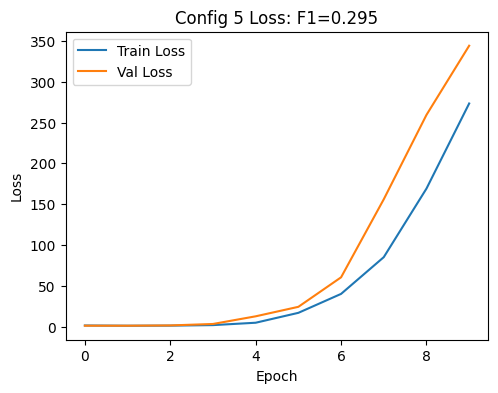

In [ ]:
# Config 5
config = hyperparameter_configs[4]
print(f"\n--- Training Model with Configuration 5: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Config 5 - Test Macro F1-Score: {macro_f1:.4f}")
results.append({'config': config, 'history': history.history, 'macro_f1': macro_f1})
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Config 5 Loss: F1={macro_f1:.3f}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
if macro_f1 > best_f1_score:
    best_f1_score = macro_f1
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 6: {'num_conv_layers': 2, 'filters_per_layer': [32, 64], 'filter_size': (5, 5), 'pooling_type': 'max'} ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,402 (2.21 MB)

 Trainable params: 579,402 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3688 - loss: 1.7431 - val_accuracy: 0.5405 - val_loss: 1.3307
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3688 - loss: 1.7431 - val_accuracy: 0.5405 - val_loss: 1.3307
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5317 - loss: 1.4036 - val_accuracy: 0.4380 - val_loss: 2.3243
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5317 - loss: 1.4036 - val_accuracy: 0.4380 - val_loss: 2.3243
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4511 - loss: 3.4111 - val_accuracy: 0.3703 - val_loss: 14.9596
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4511 - loss: 3.4111 - val_accuracy: 0.3703 - val_loss: 14.9596
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3909 - loss: 22.9810 - val_accuracy: 0.3635 - val_loss: 49.1457
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.39

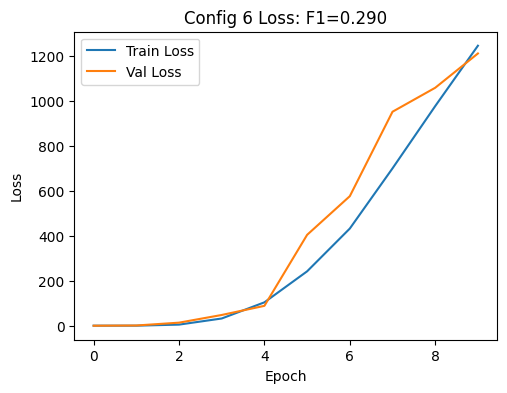

In [ ]:
# Config 6
config = hyperparameter_configs[5]
print(f"\n--- Training Model with Configuration 6: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Config 6 - Test Macro F1-Score: {macro_f1:.4f}")
results.append({'config': config, 'history': history.history, 'macro_f1': macro_f1})
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Config 6 Loss: F1={macro_f1:.3f}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
if macro_f1 > best_f1_score:
    best_f1_score = macro_f1
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Training Model with Configuration 7: {'num_conv_layers': 2, 'filters_per_layer': [32, 64], 'filter_size': (3, 3), 'pooling_type': 'avg'} ---


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 16, 16, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 8, 8, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3534 - loss: 1.7793 - val_accuracy: 0.5147 - val_loss: 1.3736
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3534 - loss: 1.7793 - val_accuracy: 0.5147 - val_loss: 1.3736
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5337 - loss: 1.3181 - val_accuracy: 0.4812 - val_loss: 1.6611
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5337 - loss: 1.3181 - val_accuracy: 0.4812 - val_loss: 1.6611
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5390 - loss: 1.3917 - val_accuracy: 0.4875 - val_loss: 1.7139
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5390 - loss: 1.3917 - val_accuracy: 0.4875 - val_loss: 1.7139
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4927 - loss: 2.0383 - val_accuracy: 0.4339 - val_loss: 3.9601
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4927 -

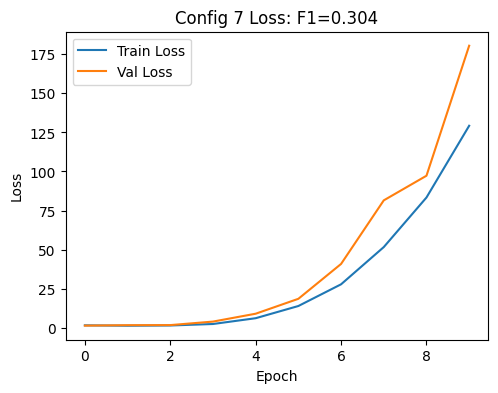

In [ ]:
# Config 7
config = hyperparameter_configs[6]
print(f"\n--- Training Model with Configuration 7: {config} ---")
model = build_cnn_model(**config, input_shape=input_shape, num_classes=num_classes)
model.summary()
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose=1)
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Config 7 - Test Macro F1-Score: {macro_f1:.4f}")
results.append({'config': config, 'history': history.history, 'macro_f1': macro_f1})
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Config 7 Loss: F1={macro_f1:.3f}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
if macro_f1 > best_f1_score:
    best_f1_score = macro_f1
    best_model_config = config
    best_keras_model = model
    print(f"New best model found with F1-score: {best_f1_score:.4f}")


--- Best Model Configuration ---
{'num_conv_layers': 3, 'filters_per_layer': [32, 64, 128], 'filter_size': (3, 3), 'pooling_type': 'max'}
Best Test Macro F1-Score: 0.4738
Saved best Keras model weights to cnn_keras.weights.h5

Re-training the best model for more epochs (e.g., 50)...
Saved best Keras model weights to cnn_keras.weights.h5

Re-training the best model for more epochs (e.g., 50)...


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3548 - loss: 1.7627 - val_accuracy: 0.5521 - val_loss: 1.2571
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3548 - loss: 1.7627 - val_accuracy: 0.5521 - val_loss: 1.2571
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5647 - loss: 1.2473 - val_accuracy: 0.6013 - val_loss: 1.1785
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5647 - loss: 1.2473 - val_accuracy: 0.6013 - val_loss: 1.1785
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5686 - loss: 1.4789 - val_accuracy: 0.5533 - val_loss: 1.9555
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5686 - loss: 1.4789 - val_accuracy: 0.5533 - val_loss: 1.9555
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.4985 - loss: 4.2438 - val_accuracy: 0.4370 - val_loss: 18.2914
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.4985 

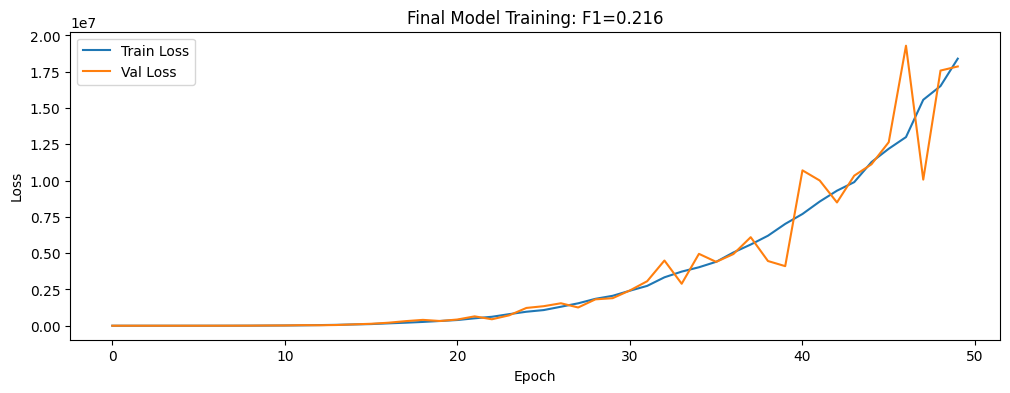

In [ ]:
# Summary and best model logic
print(f"\n--- Best Model Configuration ---")
print(best_model_config)
print(f"Best Test Macro F1-Score: {best_f1_score:.4f}")

if best_keras_model:
    best_keras_model.save_weights('cnn_keras.weights.h5')
    print("Saved best Keras model weights to cnn_keras.weights.h5")
    print("\nRe-training the best model for more epochs (e.g., 50)...")
    final_model = build_cnn_model(**best_model_config, input_shape=input_shape, num_classes=num_classes)
    final_model.summary()
    final_history = final_model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), verbose=1)
    final_y_pred_proba = final_model.predict(x_test)
    final_y_pred = np.argmax(final_y_pred_proba, axis=1)
    final_macro_f1 = f1_score(y_test, final_y_pred, average='macro')
    print(f"Final Model Test Macro F1-Score after extended training: {final_macro_f1:.4f}")
    final_model.save_weights('cnn_keras_final.weights.h5')
    print("Saved final Keras model weights to cnn_keras_final.weights.h5")
    plt.figure(figsize=(12, 4))
    plt.plot(final_history.history['loss'], label='Train Loss')
    plt.plot(final_history.history['val_loss'], label='Val Loss')
    plt.title(f"Final Model Training: F1={final_macro_f1:.3f}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    print("No model was trained successfully to save weights.")